In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import timedelta
import simulate
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 100)

In [58]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

start = dt.date(2020, 1, 1)
end = dt.date(2080, 12, 31)


Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

## Setting up functions to calculate performance

In [59]:
def nd(s, pv_u, dst, td, cash, phase, g):
    # determine new debt dependent on phase
	# dont aquire debt or repay debt in phase 3 or 4
    if phase == 3 or phase == 4:
        return 0, s
    
    if phase == 1:
        upper_debt_limit = pv_u/(1+g)
        new_debt = min(max(g*s, g*(pv_u-td)), dst-pv_u-s)
        return (new_debt, s)
    
    if phase == 2: 
        stocks_sold = max(pv_u-dst, 0)
        debt_repayment = min(td, s + stocks_sold)
        leftover_savings = max(s-debt_repayment - stocks_sold, 0)
        return -debt_repayment, leftover_savings

In [60]:
def update_cash(phase, pv_u, tv_u, s, cash, pi_rf, pi_hat):
    if phase <= 3:
        return 0, s
    
    if phase == 4:
        desired_cash = (pi_hat-pi_rf)*(tv_u+s)
        desired_savings = (pi_rf - pi_hat)*(tv_u+s)
        return desired_cash, desired_savings

In [61]:
def phase_check(phase, pi_rf, pi_rm, pi_hat, td):
    if phase == 4:
        return 4
    
    if td > 0:
        #has target not been reached?
        if pi_hat < pi_rm and phase <= 1:
            return 1
        else:
            # if target has been reached once and debt remains, stay in phase 2
            return 2
    
    #if target has been reached and no debt remains
    #is the value still above the target?
    if pi_hat < pi_rf:
        return 3
    else:
        return 4

In [62]:
def calc_pi(gamma, sigma, mr, rate, cost = 0):
    return (mr - cost - rate)/(gamma * sigma)

## Combining with investment profile

In [63]:
savings = pd.read_csv('investment_plan.csv', sep=';', index_col=0)['Earnings'].values

In [64]:
def calculate_return(savings, market_returns, gearing_cap, pi_rf, pi_rm, rf, rm):
    
    # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    # Setting up constants and dataframe for calculation
    ses = savings.sum()     # Possibly add more sophisticated discounting
    ist = pi_rm*ses
    columns = ['period', 'savings', 'cash', 'new_debt', 'total_debt', 'nip', 'pv_p', 
               'interest', 'market_returns', 'pv_u', 'tv_u', 'dst', 'phase', 'pi_hat', 'ses']
    
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    
    pp['ses'] = ses
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    
                      
    # Period 0 primo
    pp.loc[0, 'cash'] = 0
    pp.loc[0, 'new_debt'] = pp.loc[0, 'savings']*gearing_cap
    pp.loc[0, 'total_debt'] = pp.loc[0, 'new_debt']
    pp.loc[0, 'nip'] = pp.loc[0, 'new_debt'] + pp.loc[0, 'savings']
    pp.loc[0, 'pv_p'] = pp.loc[0, 'nip']
    pp.loc[0, 'pi_hat'] =  pp.loc[0, 'pv_p']/ses
    
    # Period 0 ultimo
    pp.loc[0, 'interest'] = pp.loc[0, 'new_debt']*rm                   
    pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']                 
    pp.loc[0, 'tv_u'] = pp.loc[0, 'pv_u'] + pp.loc[0, 'cash']
    pp.loc[0, 'dst'] = ist
    pp.loc[0, 'phase'] = 1
    
              
    
    # Looping over all reminaning periods
    for i in range(1, len(savings)):
 

        # Period t > 0 primo
        pp.loc[i, 'cash'] = pp.loc[i-1, 'cash']*(1+rf) 
        pp.loc[i, 'new_debt'], pp.loc[i, 'savings'] = nd(pp.loc[i, 'savings'], pp.loc[i-1, 'pv_u'], 
                                                         pp.loc[i-1, 'dst'], pp.loc[i-1, 'total_debt'],
                                                         pp.loc[i-1, 'cash'], pp.loc[i-1, 'phase'], gearing_cap)
        pp.loc[i, 'total_debt'] = pp.loc[i-1, 'total_debt'] + pp.loc[i, 'new_debt']
        
        pp.loc[i, 'cash'], pp.loc[i, 'savings'] = update_cash(pp.loc[i-1, 'phase'], pp.loc[i-1, 'pv_u'], pp.loc[i-1, 'tv_u'],
                                                                     pp.loc[i, 'savings'], pp.loc[i, 'cash'], pi_rf, pp.loc[i-1, 'pi_hat'])

        pp.loc[i, 'nip'] = pp.loc[i, 'savings'] + max(0, pp.loc[i, 'new_debt'])
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'pv_u'] + pp.loc[i, 'nip']        
        
        
        # Period t > 0 ultimo
        pp.loc[i, 'interest'] = max(pp.loc[i, 'total_debt']*rm, 0)
        pp.loc[i, 'pv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])-pp.loc[i, 'interest']
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_u'] + pp.loc[i, 'cash']
        pp.loc[i, 'pi_hat'] = min(pp.loc[i, 'pv_u']/ses, pp.loc[i, 'pv_u']/pp.loc[i, 'tv_u'])
        
        pp.loc[i, 'phase'] = phase_check(pp.loc[i-1, 'phase'], pi_rf, pi_rm, pp.loc[i, 'pi_hat'], pp.loc[i, 'total_debt'])
        target_pi = pi_rm if pp.loc[i-1, 'phase'] < 3 else pi_rf
        pp.loc[i, 'dst'] = max(pp.loc[i, 'tv_u']*target_pi, ist)  # Moving stock target

    return pp

In [80]:
def calculate100return(savings, market_returns):
     # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    columns = ['period', 'savings', 'pv_p', 'market_returns', 'tv_u']
        
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    pp.loc[0, 'pv_p'] = pp.loc[0, 'savings']
    pp.loc[0, 'tv_u'] = pp.loc[0, 'savings']
    
    for i in range(1, len(savings)):
 
        # Period t > 0 primo
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'tv_u'] + pp.loc[i, 'savings']        
        
        # Period t > 0 ultimo
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])
    
    return pp

In [90]:
investments = savings*0.05

rf = 0.02
rm = 0.03

gamma = 1.5
sigma = 0.20**2
mr = 0.07

pi_rf = calc_pi(gamma, sigma, mr, rf, cost = 0)
pi_rm = calc_pi(gamma, sigma, mr, rm, cost = 0)

market = Market.norm_innovations().asfreq('BYS', 'pad')

port = calculate_return(investments, market['Price'].pct_change().values, 1, pi_rf, pi_rm, rf, rm)
port100 = calculate100return(investments, market['Price'].pct_change().values)

In [91]:
port100

,period,savings,pv_p,market_returns,tv_u
0,0,"20,000.00","20,000.00",0.00,"20,000.00"
1,1,"21,000.00","41,000.00",-0.04,"39,447.66"
2,2,"22,050.00","61,497.66",-0.06,"57,657.06"
3,3,"23,152.60","80,809.66",0.24,"100,033.83"
4,4,"24,310.20","124,344.03",0.27,"158,469.00"
5,5,"25,525.60","183,994.60",-0.00,"183,580.88"
6,6,"26,802.00","210,382.88",0.09,"229,983.12"
7,7,"28,142.00","258,125.12",0.04,"267,275.56"
8,8,"29,549.20","296,824.76",0.01,"300,775.22"
9,9,"31,026.60","331,801.82",0.12,"371,033.33"


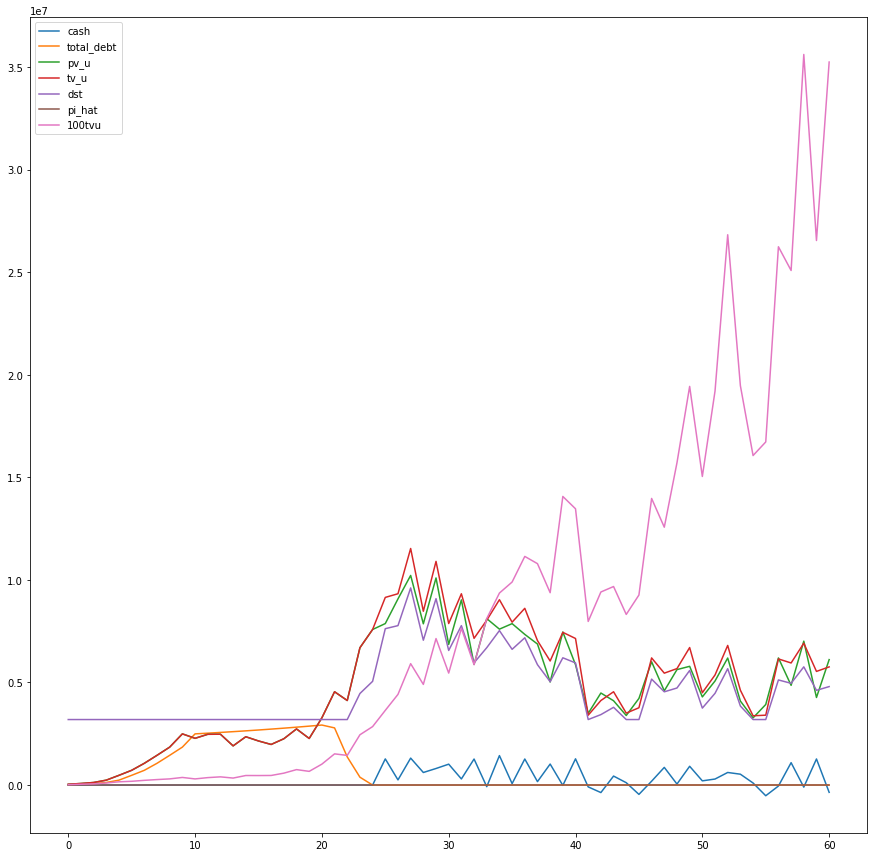

In [92]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
vars_to_plot = ['cash', 'total_debt', 'pv_u', 'tv_u', 'dst', 'pi_hat', '100tvu']
port['100tvu'] = port100['tv_u']
ax.plot(port.loc[:,vars_to_plot])
ax.legend(vars_to_plot)

In [67]:
port

,period,savings,cash,new_debt,total_debt,nip,pv_p,interest,market_returns,pv_u,tv_u,dst,phase,pi_hat,ses
0,0,"20,000.00",0.00,"20,000.00","20,000.00","40,000.00","40,000.00",600.00,0.00,"40,000.00","40,000.00","3,193,289.20",1.00,0.01,"4,789,933.80"
1,1,"21,000.00",0.00,"21,000.00","41,000.00","42,000.00","82,000.00","1,230.00",0.09,"88,499.43","88,499.43","3,193,289.20",1.00,0.02,"4,789,933.80"
2,2,"22,050.00",0.00,"47,499.43","88,499.43","69,549.43","158,048.86","2,654.98",0.12,"173,618.46","173,618.46","3,193,289.20",1.00,0.04,"4,789,933.80"
3,3,"23,152.60",0.00,"85,119.03","173,618.46","108,271.63","281,890.09","5,208.55",-0.06,"258,889.77","258,889.77","3,193,289.20",1.00,0.05,"4,789,933.80"
4,4,"24,310.20",0.00,"85,271.31","258,889.77","109,581.51","368,471.27","7,766.69",0.07,"386,628.47","386,628.47","3,193,289.20",1.00,0.08,"4,789,933.80"
5,5,"25,525.60",0.00,"127,738.71","386,628.47","153,264.31","539,892.78","11,598.85",0.23,"650,789.41","650,789.41","3,193,289.20",1.00,0.14,"4,789,933.80"
6,6,"26,802.00",0.00,"264,160.94","650,789.41","290,962.94","941,752.35","19,523.68",0.24,"1,150,797.34","1,150,797.34","3,193,289.20",1.00,0.24,"4,789,933.80"
7,7,"28,142.00",0.00,"500,007.93","1,150,797.34","528,149.93","1,678,947.28","34,523.92",0.20,"1,982,457.88","1,982,457.88","3,193,289.20",1.00,0.41,"4,789,933.80"
8,8,"29,549.20",0.00,"831,660.53","1,982,457.88","861,209.73","2,843,667.61","59,473.74",0.17,"3,265,608.39","3,265,608.39","3,193,289.20",2.00,0.68,"4,789,933.80"
9,9,0.00,0.00,"-103,345.79","1,879,112.09",0.00,"3,265,608.39","56,373.36",-0.67,"1,013,782.88","1,013,782.88","3,193,289.20",2.00,0.21,"4,789,933.80"
